In [1]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop

import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Plot training & validation accuracy values: https://keras.io/visualization/#training-history-visualization
plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots

In [2]:
#get consistent results
from keras.models import Sequential
from keras.layers import Dense
import numpy
from numpy.random import seed
seed(42)

In [ ]:
# declare lists for accuracy and loss for further visualisations
all_accs = []
all_val_accs = []
all_losses = []
all_val_losses = []

# Klasyfikacja wieloklasowa

Dataset: <br>
https://www.kaggle.com/datasets/kukuroo3/body-performance-data

Na podstawie datasetu przewidywana będzie klasa sprawności człowieka na podstawie danych o sprawności fizycznej oraz stanie ciała człowieka. Są 4 klasy sprawności:
```
class : A,B,C,D ( A: best) 

```

In [3]:
# load the data
path = r"/content/bodyPerformance.csv"
df = pd.read_csv(path)

In [4]:
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [5]:
df.describe()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm
count,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000,13393.000000
mean,36.775106,168.559807,67.447316,23.240165,78.796842,130.234817,36.963877,15.209268,39.771224,190.129627
std,13.625639,8.426583,11.949666,7.256844,10.742033,14.713954,10.624864,8.456677,14.276698,39.868000
min,21.000000,125.000000,26.300000,3.000000,0.000000,0.000000,0.000000,-25.000000,0.000000,0.000000
25%,25.000000,162.400000,58.200000,18.000000,71.000000,120.000000,27.500000,10.900000,30.000000,162.000000
50%,32.000000,169.200000,67.400000,22.800000,79.000000,130.000000,37.900000,16.200000,41.000000,193.000000
75%,48.000000,174.800000,75.300000,28.000000,86.000000,141.000000,45.200000,20.700000,50.000000,221.000000
max,64.000000,193.800000,138.100000,78.400000,156.200000,201.000000,70.500000,213.000000,80.000000,303.000000


Aby dane nadawały się do nauki sieci trzeba wykonać one-hot encoding na wartościach `gender` oraz `class`

In [18]:
prepared_df = df.join(pd.get_dummies(df['gender'], prefix='gender'))
prepared_df.drop(columns=['gender'], inplace=True)
prepared_df = prepared_df.join(pd.get_dummies(df['class'], prefix='class'))
prepared_df.drop(columns=['class'], inplace=True)
prepared_df.head()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,0,1,0,0,1,0
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0,1,1,0,0,0
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,0,1,0,0,1,0
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,0,1,0,1,0,0
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,0,1,0,1,0,0


### Skalowanie danych

In [19]:
cols_to_scale = list(prepared_df.columns[:-4])
# it's not needed to scale the target value so it's removed from the list of columns to scale
print(cols_to_scale)

['age', 'height_cm', 'weight_kg', 'body fat_%', 'diastolic', 'systolic', 'gripForce', 'sit and bend forward_cm', 'sit-ups counts', 'broad jump_cm', 'gender_F', 'gender_M']


In [22]:
normalized_df = prepared_df.copy()
# it's not needed to scale the target value
for column in cols_to_scale:
    normalized_df[column] = (prepared_df[column] - prepared_df[column].mean()) / prepared_df[column].std()
normalized_df.head()

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,-0.717405,0.443856,0.652126,-0.267357,0.112005,-0.015959,1.688127,0.377303,1.416909,0.673983,-0.762722,0.762722,0,0,1,0
1,-0.864187,-0.422450,-0.974698,-1.039042,-0.167272,-0.287810,-0.053071,0.128979,0.926599,0.974977,-0.762722,0.762722,1,0,0,0
2,-0.423841,1.310163,0.883094,-0.432718,1.229112,1.479221,0.737527,-0.379495,0.646422,-0.228996,-0.762722,0.762722,0,0,1,0
3,-0.350450,0.704935,0.305672,-0.666979,-0.260364,1.139407,0.417523,-0.001096,0.926599,0.724149,-0.762722,0.762722,0,1,0,0
4,-0.644014,0.621865,0.021146,-0.846121,-0.818918,-0.219847,0.615172,1.406076,0.366245,0.673983,-0.762722,0.762722,0,1,0,0


### Przygotowanie zbioru treningowego, walidacyjnego, testowego 

In [29]:
X, y = normalized_df.drop(normalized_df.filter(regex='class').columns, axis=1), normalized_df[normalized_df.filter(regex='class').columns]

# set how many records to use
# data_size = len(normalized_df.index)

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

In [30]:
train_data

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M
8045,-0.717405,0.621865,1.636254,0.118486,1.508388,1.886997,0.276344,0.862127,0.716467,-0.028334,-0.762722,0.762722
12964,-1.084361,-0.932740,-1.811541,0.022025,0.018912,-0.355772,-1.238969,2.009150,-0.334197,-1.182142,1.310996,-1.310996
12642,0.897198,-2.214398,-0.489329,2.405982,1.508388,-0.083921,-1.342500,0.471903,-2.225390,-1.056728,1.310996,-1.310996
9002,-0.056886,1.310163,1.142516,-1.011482,0.112005,0.052004,1.339888,-0.994394,0.436290,0.648901,-0.762722,0.762722
12596,-0.497232,0.004770,0.183493,-0.184676,1.880757,0.459780,0.633996,0.672928,1.346864,1.301053,-0.762722,0.762722
...,...,...,...,...,...,...,...,...,...,...,...,...
11964,-1.010970,1.274561,1.242937,-0.157116,0.949835,0.595706,1.085767,0.412778,0.926599,1.677294,-0.762722,0.762722
5191,-0.203668,0.277716,-0.171328,-0.666979,-1.563656,-1.103362,-0.438959,-1.431918,0.296201,0.899728,-0.762722,0.762722
5390,-0.717405,-0.007097,-1.506930,-1.011482,-0.818918,-0.967437,-1.107203,0.732053,0.506334,-0.203914,1.310996,-1.310996
860,-1.157752,0.111575,1.360095,2.709144,-0.539641,0.527743,-1.446030,0.601978,0.226157,-0.605238,1.310996,-1.310996


In [31]:
train_targets

,class_A,class_B,class_C,class_D
8045,0,0,0,1
12964,0,1,0,0
12642,0,0,0,1
9002,0,0,1,0
12596,1,0,0,0
...,...,...,...,...
11964,0,1,0,0
5191,0,0,0,1
5390,1,0,0,0
860,0,0,0,1


In [34]:
print(len(train_data), len(val_data), len(test_data))

10714 1339 1340


### Budowa sieci neuronowej


In [61]:
no_classes = 4

def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(no_classes, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    return model

In [43]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=256,
                    validation_data=(val_data, val_targets))

Epoch 1/20
42/42 [==============================] - 1s 7ms/step - loss: 1.2097 - accuracy: 0.4649 - val_loss: 1.0497 - val_accuracy: 0.5400
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 0.9816 - accuracy: 0.5684 - val_loss: 0.9143 - val_accuracy: 0.5937
Epoch 3/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8862 - accuracy: 0.6059 - val_loss: 0.8578 - val_accuracy: 0.6318
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8478 - accuracy: 0.6225 - val_loss: 0.8360 - val_accuracy: 0.6333
Epoch 5/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8263 - accuracy: 0.6331 - val_loss: 0.8184 - val_accuracy: 0.6542
Epoch 6/20
42/42 [==============================] - 0s 3ms/step - loss: 0.8093 - accuracy: 0.6450 - val_loss: 0.8016 - val_accuracy: 0.6609
Epoch 7/20
42/42 [==============================] - 0s 3ms/step - loss: 0.7942 - accuracy: 0.6500 - val_loss: 0.7843 - val_accuracy: 0.6609
Epoch 8/20
42/42 [==

In [46]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

all_accs.append(acc)
all_val_accs.append(val_acc)
all_losses.append(loss)
all_val_losses.append(val_loss)

In [48]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
def PlotMultipleAccuracyComparison(accs ,val_accs):
    plt.clf()   # clear figure
    #acc = history1_dict['accuracy']
    #val_acc = history1_dict['val_accuracy']
    epochs = range(len(accs[0]))
    for i,  (acc, val_acc, color) in enumerate(zip(accs, val_accs, colors)):
            plt.plot(epochs, acc, f'{color}o', label=f'Training accuracy of model {i+1}')
            plt.plot(epochs, val_acc, f'{color}', label=f'Validation accuracy of model {i+1}')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
def PlotMultipleLossComparison(losses, val_losses):
    plt.clf()   # clear figure
    epochs = range(len(losses[0]))
    for i,  (loss, val_loss, color) in enumerate(zip(losses, val_losses, colors)):
        plt.plot(epochs, loss, f'{color}o', label=f'Training loss of model {i+1}')
        plt.plot(epochs, val_loss, f'{color}', label=f'Validation loss of model {i+1}')
    plt.title('Training and validation loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

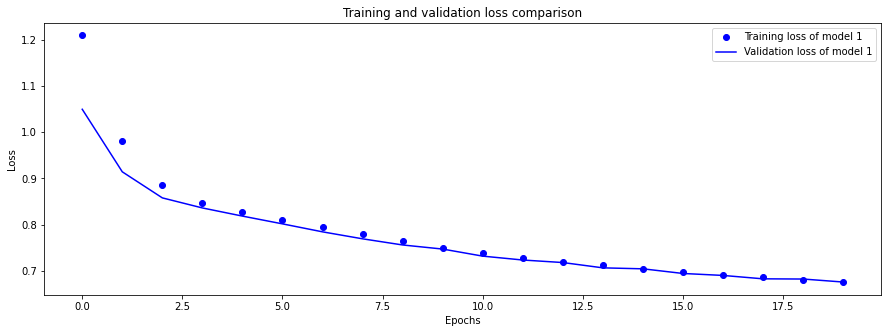

In [49]:
PlotMultipleLossComparison([loss], [val_loss])

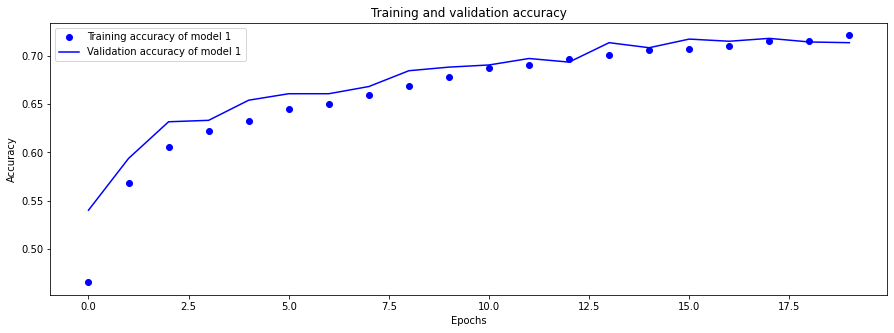

In [52]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Otrzymany wynik jest zaskakujący, accuracy treningowe jest niższe od walidacyjnego. Może to oznaczać, że skalowanie danych gra tu rolę i prowadzi do underfittingu. 

Sprawdźmy jak model uczy się na danych nieprzeskalowanych:

In [53]:
prepared_df

,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,gender_F,gender_M,class_A,class_B,class_C,class_D
0,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,0,1,0,0,1,0
1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0,1,1,0,0,0
2,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,0,1,0,0,1,0
3,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,0,1,0,1,0,0
4,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13388,25.0,172.1,71.80,16.2,74.0,141.0,35.8,17.4,47.0,198.0,0,1,0,0,1,0
13389,21.0,179.7,63.90,12.1,74.0,128.0,33.0,1.1,48.0,167.0,0,1,0,0,0,1
13390,39.0,177.2,80.50,20.1,78.0,132.0,63.5,16.4,45.0,229.0,0,1,1,0,0,0
13391,64.0,146.1,57.70,40.4,68.0,121.0,19.3,9.2,0.0,75.0,1,0,0,0,0,1


In [54]:
X, y = prepared_df.drop(prepared_df.filter(regex='class').columns, axis=1), prepared_df[normalized_df.filter(regex='class').columns]

# set how many records to use
# data_size = len(normalized_df.index)

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

In [55]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=20,
                    batch_size=256,
                    validation_data=(val_data, val_targets))

Epoch 1/20
42/42 [==============================] - 1s 7ms/step - loss: 3.2110 - accuracy: 0.3646 - val_loss: 3.5269 - val_accuracy: 0.3652
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 2.2443 - accuracy: 0.3946 - val_loss: 1.7336 - val_accuracy: 0.4197
Epoch 3/20
42/42 [==============================] - 0s 3ms/step - loss: 2.0611 - accuracy: 0.4308 - val_loss: 1.5338 - val_accuracy: 0.4122
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 1.9882 - accuracy: 0.4245 - val_loss: 1.6249 - val_accuracy: 0.4018
Epoch 5/20
42/42 [==============================] - 0s 3ms/step - loss: 1.8215 - accuracy: 0.4501 - val_loss: 2.3836 - val_accuracy: 0.3928
Epoch 6/20
42/42 [==============================] - 0s 3ms/step - loss: 1.8179 - accuracy: 0.4664 - val_loss: 1.4591 - val_accuracy: 0.4839
Epoch 7/20
42/42 [==============================] - 0s 3ms/step - loss: 1.7945 - accuracy: 0.4710 - val_loss: 1.4543 - val_accuracy: 0.4003
Epoch 8/20
42/42 [==

In [56]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

all_accs.append(acc)
all_val_accs.append(val_acc)
all_losses.append(loss)
all_val_losses.append(val_loss)

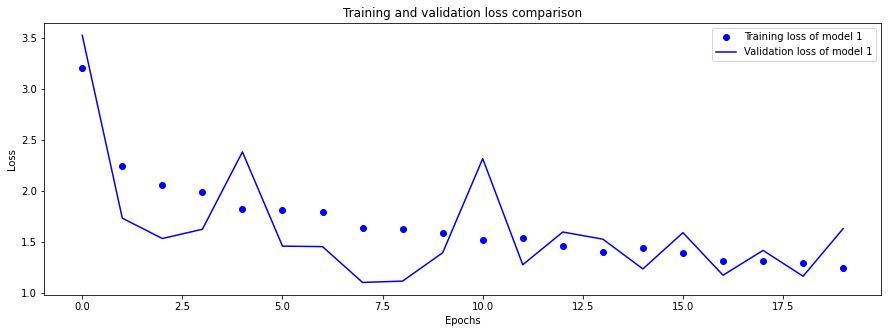

In [57]:
PlotMultipleLossComparison([loss], [val_loss])

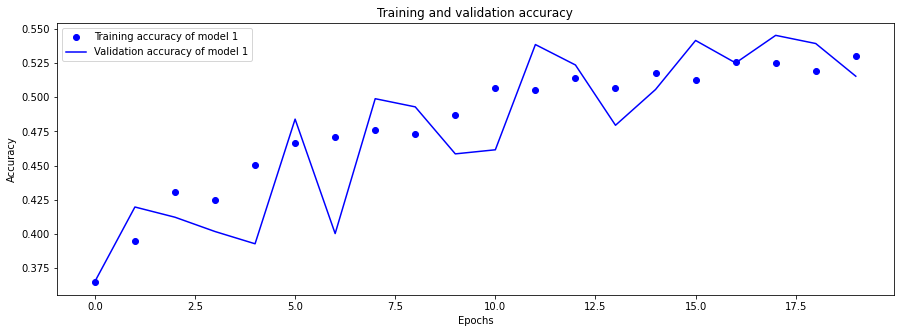

In [58]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Brak skalowania danych jedynie pogorszył wyniki accuracy oraz loss, lecz nadal wyglądają one podobnie do tych ze skalowaniem.

Pora powrócić do skalowanych danych i zmienić architekturę sieci oraz ilość epok.

In [59]:
X, y = normalized_df.drop(normalized_df.filter(regex='class').columns, axis=1), normalized_df[normalized_df.filter(regex='class').columns]

# set how many records to use
# data_size = len(normalized_df.index)

# In the first step we will split the data in training and remaining dataset
train_data, rem_data, train_targets, rem_targets = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

# split remaining data to test and validation sets
test_size=0.5
val_data, test_data, val_targets, test_targets = train_test_split(rem_data,rem_targets, test_size=test_size, random_state=42) 

Spróbujmy zwiększyć ilość epok w tym samym modelu.

In [64]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=50,
                    batch_size=16,
                    validation_data=(val_data, val_targets))

Epoch 1/50
670/670 [==============================] - 2s 2ms/step - loss: 0.9218 - accuracy: 0.5931 - val_loss: 0.8057 - val_accuracy: 0.6438
Epoch 2/50
670/670 [==============================] - 1s 2ms/step - loss: 0.7718 - accuracy: 0.6648 - val_loss: 0.7425 - val_accuracy: 0.6886
Epoch 3/50
670/670 [==============================] - 1s 2ms/step - loss: 0.7212 - accuracy: 0.6951 - val_loss: 0.7101 - val_accuracy: 0.7132
Epoch 4/50
670/670 [==============================] - 1s 2ms/step - loss: 0.6937 - accuracy: 0.7098 - val_loss: 0.6795 - val_accuracy: 0.7244
Epoch 5/50
670/670 [==============================] - 1s 2ms/step - loss: 0.6734 - accuracy: 0.7223 - val_loss: 0.6613 - val_accuracy: 0.7184
Epoch 6/50
670/670 [==============================] - 1s 2ms/step - loss: 0.6578 - accuracy: 0.7304 - val_loss: 0.6532 - val_accuracy: 0.7356
Epoch 7/50
670/670 [==============================] - 1s 2ms/step - loss: 0.6474 - accuracy: 0.7304 - val_loss: 0.6401 - val_accuracy: 0.7334
Epoch 

In [66]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

all_accs.append(acc)
all_val_accs.append(val_acc)
all_losses.append(loss)
all_val_losses.append(val_loss)

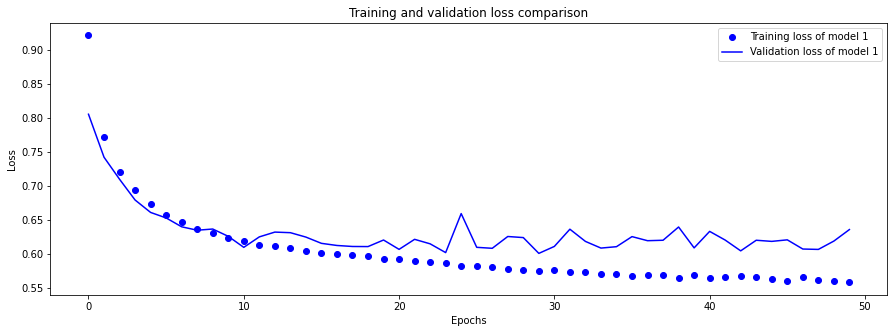

In [67]:
PlotMultipleLossComparison([loss], [val_loss])

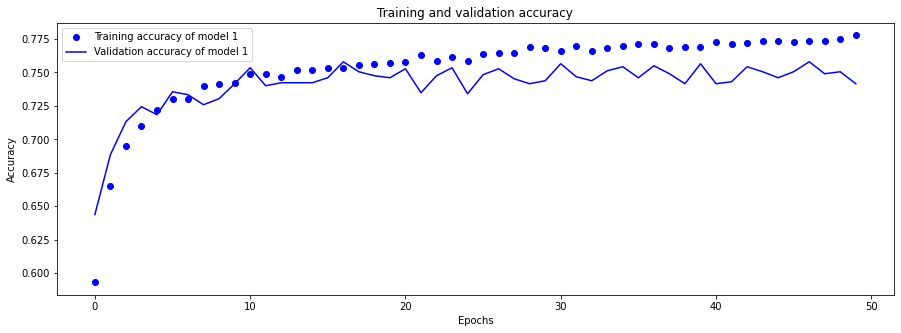

In [68]:
PlotMultipleAccuracyComparison([acc], [val_acc])

 Do około 10 epoki accuracy oraz loss zarówno w zbiorze treningowym jak i walidacyjnym są takie same - występuje underfitting.

#### Kolejny model

In [80]:
no_classes = 4

def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(no_classes, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    return model

In [81]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=100,
                    batch_size=256,
                    validation_data=(val_data, val_targets))

Epoch 1/100
42/42 [==============================] - 1s 8ms/step - loss: 1.0513 - accuracy: 0.5280 - val_loss: 0.8828 - val_accuracy: 0.6258
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 0.8427 - accuracy: 0.6302 - val_loss: 0.8192 - val_accuracy: 0.6497
Epoch 3/100
42/42 [==============================] - 0s 5ms/step - loss: 0.8001 - accuracy: 0.6499 - val_loss: 0.7917 - val_accuracy: 0.6639
Epoch 4/100
42/42 [==============================] - 0s 10ms/step - loss: 0.7677 - accuracy: 0.6699 - val_loss: 0.7716 - val_accuracy: 0.6692
Epoch 5/100
42/42 [==============================] - 1s 12ms/step - loss: 0.7442 - accuracy: 0.6863 - val_loss: 0.7263 - val_accuracy: 0.7110
Epoch 6/100
42/42 [==============================] - 0s 10ms/step - loss: 0.7229 - accuracy: 0.6954 - val_loss: 0.7373 - val_accuracy: 0.6759
Epoch 7/100
42/42 [==============================] - 0s 7ms/step - loss: 0.7047 - accuracy: 0.7098 - val_loss: 0.7042 - val_accuracy: 0.7058
Epoch 8/10

In [82]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

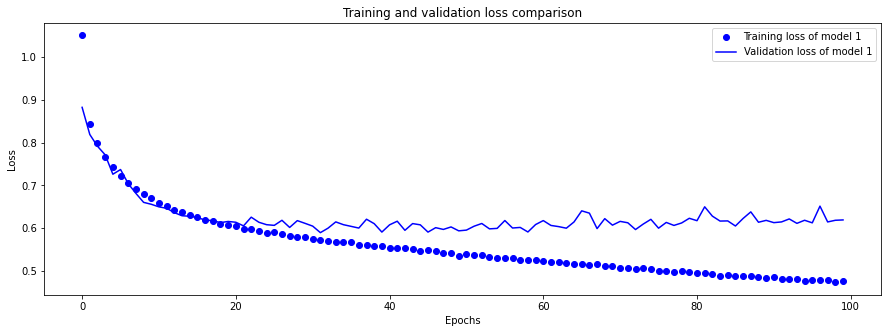

In [83]:
PlotMultipleLossComparison([loss], [val_loss])

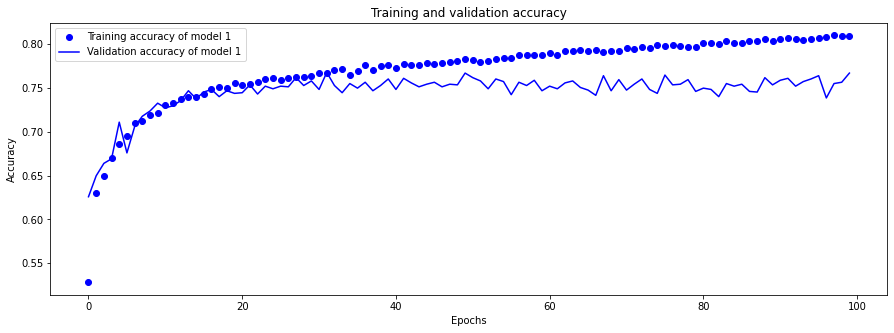

In [84]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Nadal wyniki są podobne - zwiększmy sieć jeszcze bardziej.

In [85]:
def build_model():
    # Because we will need to instantiate the same model multiple times,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(512, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(no_classes, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])    
    return model

In [86]:
model = build_model()
history = model.fit(train_data,
                    train_targets,
                    epochs=200,
                    batch_size=128,
                    validation_data=(val_data, val_targets))

Epoch 1/200
84/84 [==============================] - 2s 18ms/step - loss: 0.9343 - accuracy: 0.5812 - val_loss: 0.8022 - val_accuracy: 0.6438
Epoch 2/200
84/84 [==============================] - 1s 15ms/step - loss: 0.7733 - accuracy: 0.6618 - val_loss: 0.7181 - val_accuracy: 0.7028
Epoch 3/200
84/84 [==============================] - 1s 16ms/step - loss: 0.7089 - accuracy: 0.6995 - val_loss: 0.6407 - val_accuracy: 0.7319
Epoch 4/200
84/84 [==============================] - 1s 15ms/step - loss: 0.6734 - accuracy: 0.7154 - val_loss: 0.7333 - val_accuracy: 0.6901
Epoch 5/200
84/84 [==============================] - 1s 15ms/step - loss: 0.6566 - accuracy: 0.7205 - val_loss: 0.6290 - val_accuracy: 0.7371
Epoch 6/200
84/84 [==============================] - 1s 15ms/step - loss: 0.6382 - accuracy: 0.7342 - val_loss: 0.6337 - val_accuracy: 0.7311
Epoch 7/200
84/84 [==============================] - 1s 16ms/step - loss: 0.6295 - accuracy: 0.7399 - val_loss: 0.7618 - val_accuracy: 0.6796
Epoch 

In [90]:
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

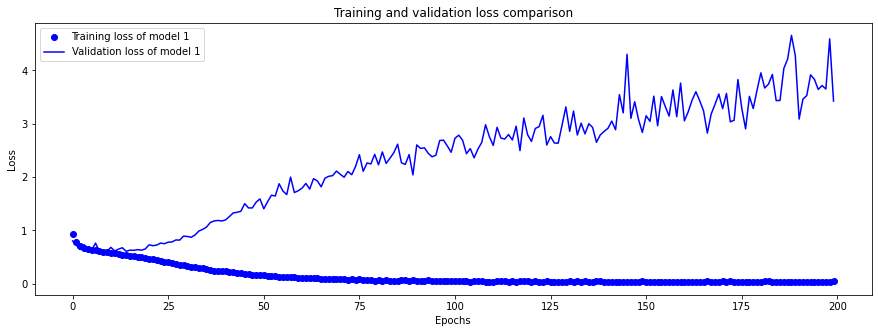

In [88]:
PlotMultipleLossComparison([loss], [val_loss])

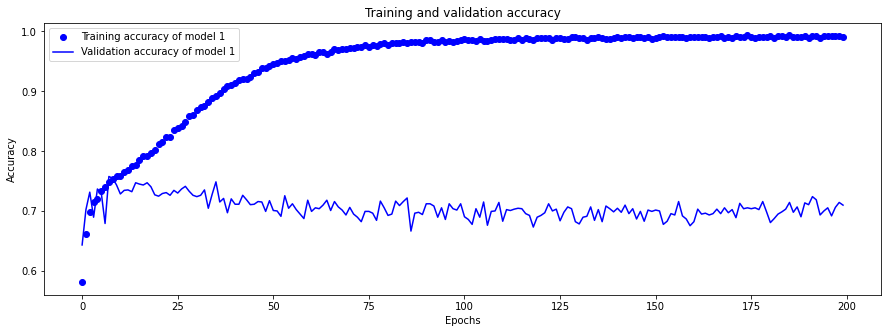

In [89]:
PlotMultipleAccuracyComparison([acc], [val_acc])

Dla tej sieci widać dość drastyczną różnicę - od około 10 epoki następuje "rajd do sufitu" treningowego accuracy, a loss spada prawie do 0. Nie było tu zaskoczenia - widać, że uczenie złożonej sieci przez dużą ilość epok sprzyja bardzo mocno overfittingowi.